# **Problem with traditional deep neural network**

# Import DataSet....

In [1]:
from torchvision import datasets
import torch
data_folder = '~/content/'
fmnist = datasets.FashionMNIST(data_folder,download=True,train=True)

In [2]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
val_fmnist = datasets.FashionMNIST(data_folder,download=True,train=False)

val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Model

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x,self.y = x,y

    def __getitem__(self,ix):
        x,y = self.x[ix],self.y[ix]
        return x.to(device),y.to(device)
    def __len__(self):
        return len(self.x)

from torch.optim import SGD,Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28,1000),
        nn.ReLU(),
        nn.Linear(1000,10)

    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(),lr = 0.001)
    return model,loss_fn,optimizer

def train_batch(x,y,model,opt,loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x,y,model):
    with torch.no_grad():
        prediction = model(x)
    max_values,argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

### **Data Loader**

In [6]:
def get_data():
    train = FMNISTDataset(tr_images,tr_targets)
    train_dl = DataLoader(train,batch_size=32,shuffle=True)
    val = FMNISTDataset(val_images,val_targets)
    val_dl = DataLoader(val,batch_size=len(tr_images),shuffle=False)
    return train_dl,val_dl

In [7]:
def val_loss(x,y,model):
    with torch.no_grad():
        prediction = model(x)
    val_loss =loss_fn(prediction,y)
    return val_loss.item()

In [8]:
train_dl,val_dl = get_data()
model ,loss_fn,optimizer = get_model() 


In [9]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x,y,model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


In [10]:
len(tr_images)

60000

fetch a random image from training


Text(0.5, 1.0, 'Trouser')

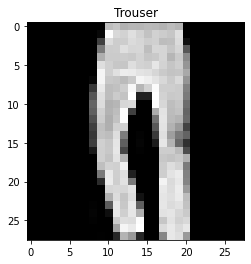

In [11]:
ix = 24300
plt.imshow(tr_images[ix],cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

# The same preprocessing steps while building a model

In [12]:
img = tr_images[ix]/255
img = img.view(28*28)
img = img.to(device)

In [13]:
# Extract propabibilties associated with various classes
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([1.7008226e-04, 9.9980569e-01, 1.5531123e-07, 4.0417854e-06,
       1.2218696e-06, 8.4108343e-10, 1.4535995e-05, 1.7563283e-15,
       4.2116608e-06, 4.3059997e-11], dtype=float32)

# Translation

In [14]:
tr_targets[ix]

tensor(1)

In roll the image is mutiple times one pixel at a time 5 pixels left 5 pixels right

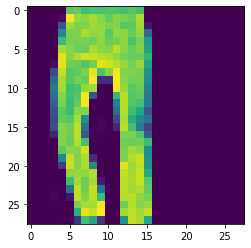

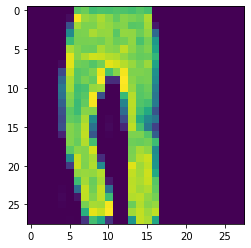

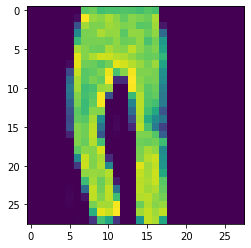

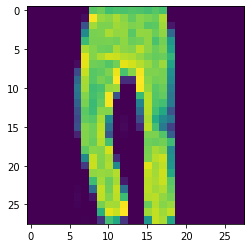

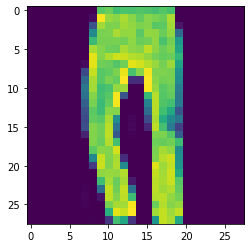

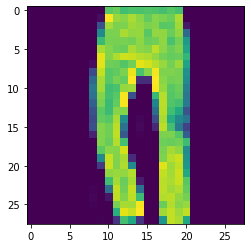

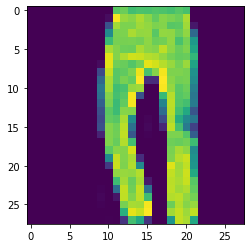

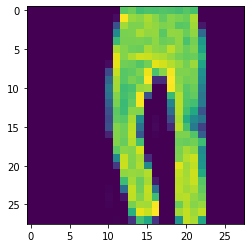

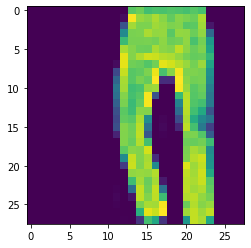

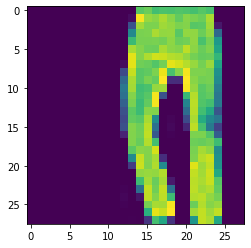

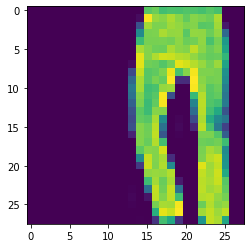

In [22]:
preds =[]
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28,28)
    img2 = np.roll(img,px,axis=1)
    plt.imshow(img2)
    plt.show()
    img3 = torch.Tensor(img2).view(28*28).to(device)
    np_output = model(img3).cpu().detach().numpy()
    preds.append(np.exp(np_output) /np.sum(np.exp(np_output)))

Vicualize the prediction of the model with all the translations(-5 to +5 pixels)

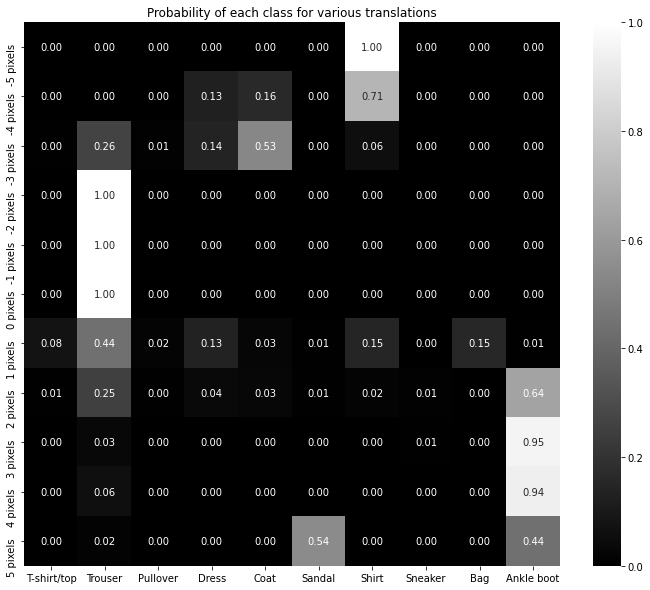

In [23]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], cmap='gray')

 we will learn about how CNNs help address this problem. But before we do this, we will learn about the building blocks of a CNN.